In [1]:
import torch
from torch import tensor
import torchvision
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from tqdm import trange
import pandas as pd
from sklearn.metrics import roc_auc_score
import numpy as np
from sklearn.model_selection import train_test_split

In [2]:
class FairLogReg(nn.Module):
    def __init__(self, D):
        super(FairLogReg, self).__init__()
        self.theta = torch.nn.Parameter(torch.zeros(D), requires_grad=True)
        self.old_theta = tensor(float("Inf"))

    def forward(self, x):
        return x.mv(self.theta)


In [3]:
def get_data(filename):
    df = pd.read_csv("data/COMPAS/" + filename + ".csv")
    y = df['two_year_recid']
    (cvXs, cvys, cvss) = ([None] * 5, [None] * 5, [None] * 5)
    (cvXts, cvyts, cvsts) = ([None] * 5, [None] * 5, [None] * 5)
    for i in range(5):
        df_train, df_test, _, _ = train_test_split(df, y, test_size=0.2)
        cvss[i] = tensor(df_train['race'].values == "Caucasian")
        cvys[i] = tensor(df_train['two_year_recid'].values == 0).float()
        X = tensor(df_train.drop(columns=['sex','race','sex-race','two_year_recid']).values).float()
        cvXs[i] = torch.cat((torch.ones(X.shape[0],1), X), dim=1)
        cvsts[i] = tensor(df_test['race'].values == "Caucasian")
        cvyts[i] = tensor(df_test['two_year_recid'].values == 0).float()
        X = tensor(df_test.drop(columns=['sex','race','sex-race','two_year_recid']).values).float()
        cvXts[i] = torch.cat((torch.ones(X.shape[0],1), X), dim=1)
    return ((cvXs, cvys, cvss), (cvXts, cvyts, cvsts))

In [4]:
# def get_data(filename):
#     df = pd.read_csv("data/Adult/" + filename + ".csv")
#     y = df['income-per-year']
#     (cvXs, cvys, cvss) = ([None] * 5, [None] * 5, [None] * 5)
#     (cvXts, cvyts, cvsts) = ([None] * 5, [None] * 5, [None] * 5)
#     for i in range(5):
#         df_train, df_test, _, _ = train_test_split(df, y, test_size=0.2)
#         cvss[i] = tensor(df_train['sex'].values == "Male")
#         cvys[i] = tensor(df_train['income-per-year'].values == ">50K").float()
#         X = tensor(df_train.drop(columns=['race','sex','income-per-year','race-sex']).values).float()
#         cvXs[i] = torch.cat((torch.ones(X.shape[0],1), X), dim=1)
#         cvsts[i] = tensor(df_test['sex'].values == "Male")
#         cvyts[i] = tensor(df_test['income-per-year'].values == ">50K").float()
#         X = tensor(df_test.drop(columns=['race','sex','income-per-year','race-sex']).values).float()
#         cvXts[i] = torch.cat((torch.ones(X.shape[0],1), X), dim=1)
#     return ((cvXs, cvys, cvss), (cvXts, cvyts, cvsts))

In [5]:
form="linear"
sum_form=-1
eoo=False
(Pa, Pb) = (tensor(1.),tensor(1.))

In [6]:
if form == "logistic":
    def g(outputs):
        return -F.logsigmoid(outputs).sum()
elif form == "hinge":
    baseline = torch.tensor(0.)
    def g(outputs):
        return torch.max(baseline,1-outputs[sens_attr]).sum()
elif form == "linear":
    def g(outputs):
        return outputs.sum()
else:
    raise ValueError("Pick a valid form!")

ploss = nn.BCEWithLogitsLoss()
def floss(outputs, sens_attr):
    return g(outputs[sens_attr])/Pa + sum_form * g(-sum_form * outputs[~sens_attr])/Pb

In [7]:
def make_closure(model, optimizer, lam_fair, lam_reg, X, y, s):
    def closure():
        assert not torch.isnan(model.theta).any()
        optimizer.zero_grad()
        outputs = model(X)
        if eoo:
            loss = ploss(outputs,y) + lam_reg * (model.theta**2).mean() + lam_fair/outputs.shape[0] * floss(outputs[y.bool()], s[y.bool()])
        else:
            loss = ploss(outputs,y) + lam_reg * (model.theta**2).mean() + lam_fair/outputs.shape[0] * floss(outputs, s)
        loss.backward()
        return loss
    return closure

In [8]:
def train_model(X,y,s,lam_fair=0, lam_reg=0):
    (Pa, Pb) = (s.float().mean(), 1 - s.float().mean())
    model = FairLogReg(X.shape[1])
    optimizer = torch.optim.LBFGS(model.parameters(), lr=1)
    closure = make_closure(model, optimizer, lam_fair, lam_reg, X, y, s)
    for t in trange(500):
        optimizer.step(closure)
        diff = (model.old_theta - model.theta).abs().max()
        if diff < 1e-6:
            break
        model.old_theta = model.theta.clone().detach()
    return model

In [28]:
i=4
((cvXs, cvys, cvss), (cvXts, cvyts, cvsts)) = get_data("train" + str(i))
aucs = []
lam_regs = 2. ** np.arange(-5,5,1)
for lam_reg in lam_regs:
    auc = 0
    for j in range(5):
        model = train_model(cvXs[j],cvys[j],cvss[j], lam_reg = lam_reg)
        outputs = model(cvXts[j]).detach()
        auc = auc + roc_auc_score(cvyts[j], outputs)
    aucs.append(auc/5)

  0%|          | 2/500 [00:00<00:02, 205.37it/s]


In [29]:
aucs

[0.7280270763790552,
 0.730162649210707,
 0.7304717790080796,
 0.7271323985148747,
 0.7187887463237688,
 0.7055338000527434,
 0.6889345437277227,
 0.6714125785112884,
 0.6578524020457006,
 0.6480535290197627]

In [30]:
np.arange(-5,5,1)[np.argmax(aucs)]

-3

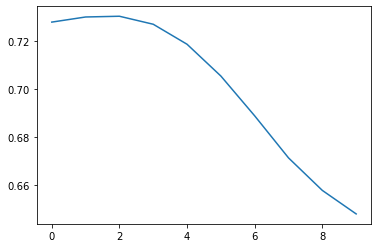

In [31]:
import matplotlib.pyplot as plt
plt.plot(aucs)